# AUTÓMATAS CELULALES
-----
## INCENDIOS FORESTALES

Por: _Arzaga Barajas Esteban, López Ángeles Diana, Molina Martinez Carol_.

Los autómatas celulares (AC) surgen en la década de 1940 con John Von Neumann, quien intentaba modelar una máquina que fuera capaz de autoreplicarse, llegando así a un modelo matemático de dicha máquina con reglas complicadas sobre una red rectangular. Inicialmente fueron interpretados como conjunto de células que crecían, se reproducían y morían a medida que pasaba el tiempo.  

Un autómata celular es un modelo matemático para un sistema dinámico, compuesto por un conjunto de celdas que adquieren distintos estados o valores. Estos estados son alterados de un instante a otro en unidades de tiempo discreto.  Cada celda poseerá un estado y el estado de dicha celda en la transición temporal siguiente dependerá de dicho estado y de los estados de la célula de la vecindad. De esta manera este conjunto de celdas logran una evolución según una determinada expresión matemática, que es sensible a los estados de las células vecinas, la cual se le conoce como regla de transición local.

Elementos de un autómata celular:

* Arreglo Regular: Ya sea un plano de 2 dimensiones o un espacio n-dimensional, este es el espacio de evoluciones, y cada división homogénea de arreglo es llamada célula.
* Conjunto de Estados: Es finito y cada elemento o célula del arreglo toma un valor de este conjunto de estados. Puede ser expresado en valores o colores.
* Configuración Inicial: Consiste en asignar un estado a cada una de las células del espacio de evolución inicial del sistema.
* Vecindades: Define el conjunto contiguo de células y posición relativa respecto a cada una de ellas. A cada vecindad diferente corresponde un elemento del conjunto de estados.
* Función Local: Es la regla de evolución que determina el comportamiento del AC. Se conforma de una célula central y sus vecindades. Define como debe cambiar de estado cada célula dependiendo de los estados anteriores de sus vecindades.

En el espacio de 2 dimensiones, las vecindades más utilizadas son la de vecindad de Von Neumann, considera los 4 vecinos adyacentes a una celda central y la vecindad de Moore, que considera a los 8 vecinos adyacentes.

Cada una de las celdas del autómata puede estar en cualquiera de los siguientes estados:

* Árbol: La celda contiene combustible (vegetación) que no se ha incendiado.
* Fuego: La celda contiene vegetación ardiendo.
* Quemada: La celda contiene vegetación que ha ardido completamente.

Nuestro autómata se rige por las siguientes reglas:

* Se considera que si estado de $(i,j) = celda$ $quemada$, entonces la celda $(i,j)$ permanece quemada. Es decir, si la celda está quemada, en el siguiente paso permanecerá igual. Sin embargo, existe una probabilidad prob_nuevo_árbol de que vuelva a crecer un árbol, esto porque sino la simulación tardaría muy poco en terminar.
* Una celda $(i,j)$ se convierte en $celda$ $fuego$ si al menos uno de sus ocho vecinos también se esta incendiando.
* Si una celda $(i,j) = celda$ $fuego$, entonces al siguiente tiempo se convertira en celda quemada.
* Si una celda $(i,j) = celda$ $árbol$, entonces existe una probabilidad prob_fuego de que esta se incendie.

Las probabilidades prob_nuevo_arbol y prob_fuego son arbitrarias.

La vecindad de Von Neumann:

![Ilustracion Vecindad de Von Neumann](vecindad_neumann.gif "Ilustracion Vecindad de Von Neumann") 

La vecindad de Moore:

![Ilustracion Vecindad de Moore](moore.ppm "Ilustracion Vecindad de Moore")

In [1]:
# Las librerías que vamos a utilizar:
using PyPlot
using PyCall
plt = PyPlot;
# @pyimport nos va a ayudar con nuestra animación
@pyimport matplotlib.animation as anim
#Con @enum tomamos como variables a los tres estados posibles para cada celda, que son celda quemada, celda árbol y celda fuego
@enum estado celda_quemada celda_árbol celda_fuego

In [2]:
# Nuestra función principal tendrá como argumentos el tiempo, las probabilidades ya antes mencionadas, la dimension arbitraria de la matriz a la que le llamaremos condiciones iniciales.
function incendio_forestal(tiempo, condiciones_iniciales,prob_fuego,prob_nuevo_árbol,dimensión)
    # Con esta función vamos a darle instrucciones de como debe propagarse el incendio:
    function evolución_incendio(región_bosque::Matrix{estado})
        # En la vecindad de Moore vamos a encontrar las ocho direcciones posibles:
        vecindad_moore = [-1 -1; -1 0; -1 1; 0 -1; 0 1; 1 -1; 1 0; 1 1]
        # Los árboles se quemarán si tienen al menos un vecino que también se este quemando 
        # Recorremos la matriz región_bosque a lo largo de las filas y las columnas
        for i in 1:size(región_bosque, 1), j in 1:size(región_bosque, 2)
            for k in 1:size(vecindad_moore, 1)
                    # Utilizamos checkbounds para ver si los índices "i + vecindad_moore[k, 1]" y "j + vecindad_moore[k, 2])" están dentro del arreglo "región_bosque".
                    # Si la celda (i,j) es vecina de alguna que este en encendida, entonces esta se vuelve celda fuego
                    if checkbounds(Bool, región_bosque, i + vecindad_moore[k, 1], j + vecindad_moore[k, 2]) &&  región_bosque[i,j]== celda_fuego
                        región_bosque[i+ vecindad_moore[k,1], j+ vecindad_moore[k,2]] = celda_fuego
                        break
                end
            end
        end
        
        # Ahora queremos que vaya checando índice por índice para saber en que estado se encuentra cada celda, y de acuerdo a ello hacer el cambio de estado:
        for i in linearindices(región_bosque)
            # Una celda con fuego se convierte en una celda quemada en el siguiente paso de tiempo
            if región_bosque[i] == celda_fuego
               región_bosque[i] = celda_quemada
            end
            # Un árbol se prende con una cierta probabilidad incluso si ningún vecino se quema
            if región_bosque[i] == celda_árbol && rand() < prob_fuego 
                región_bosque[i] = celda_fuego 
            end
            # Una celda quemada es reemplazada con un árbol con una cierta probabilidad 
            if región_bosque[i] == celda_quemada && rand() < prob_nuevo_árbol 
                región_bosque[i] = celda_árbol 
            end
        end
    end
    
    matriz_colores = zeros(dimensión,dimensión,3)
    # La matriz_estados es la que entra en nuestra función, pues queremos asignar el color a cada celda de acuerdo a su estado, para eso es la matriz_colores
    function imprimir_region_bosque(matriz_estados::Matrix{estado})
        # Recorremos matriz_estados a lo largo de las filas y las columnas
        for i in 1:size(matriz_estados, 1)
            for j in 1:size(matriz_estados, 2)
                # Aquí es donde asignamos los colores:
                matriz_colores[i,j,:] = (matriz_estados[i, j] == celda_quemada ? [0, 0, 0] : matriz_estados[i, j] == celda_árbol ? [85/255, 107/255, 47/255] : [254/255, 95/255, 30/255])
            end
        end
        # Que nos regrese nuestra matriz:
        matriz_colores
    end
    
    # Ahora queremos hacer la animación:
    function mostrar_animación(nombre_archivo)
        base64_video = base64encode(open(nombre_archivo))
        display("text/html", """<video controls src="data:video/x-m4v;base64,$base64_video">""")
    end
    
    # Le ponemos el tamaño a nuestra figura:
    fig = figure(figsize=(4,4))
    
    # Queremos una función con la cual podamos obtener cuadros o imágenes por cada tiempo:
    function cuadros(tiempo)
        # Tenemos que poner evolución pues en esta es donde ocurren los cambios de estado
        evolución_incendio(condiciones_iniciales)
        # Y con imshow ya vemos la región completa con los colores correspondientes a cada estado
        plt.imshow(imprimir_region_bosque(condiciones_iniciales))
        axis("off")
        title("Simulación de incendio forestal")
    end
    
    # Aquí van algunas de los parámetros que tomará en cuenta nuestra animación:
    withfig(fig) do
        
    # Aquí estamos diciendo que animación_incendio estará dada por fig que es nuestra figura, con los cuadros que ya se obtuvieron previamente y por último el intervalo que corresponde a los milisegundos entre cuadro y cuadro
    animación_incendio = anim.FuncAnimation(fig, cuadros, frames=tiempo, interval=100)
    animación_incendio[:save]("animación_incendio.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
    end
    
    # Finalmente que nos muestre nuestra animación terminada:
    mostrar_animación("animación_incendio.mp4")

    end

incendio_forestal (generic function with 1 method)

La matriz de condiciones_iniciales escogida tiene una dimensión de $100x100$.

In [3]:
dimensión = 100
incendio_forestal(0:50,fill(celda_árbol,dimensión,dimensión),.01,0,dimensión)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQADKFFtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0OCAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTYgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJlYWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAKrBliIQAEf/+94gfMstp+TrXchHnrS6tH1DuRnFepL3+IAAAAwLICvvBO/gmf8wDSH16FM+9M+O0NhqzHV6a1WfzJQ3SsQbO6ZnjGtwBI7vLcbqwLgTY45kp3hlHgc2UDB28IuPHLrqRaLy7ZbjQJwby2gzkIkJ/etezHq51Gc6yjp71yw0LbxkbzNgEvjedOmhExuGQ7d0f/ATyIxpfdII/nJ5hsXJsLhaDBeZc9XzHNgZ4sJTXn7tJzJJfYb6Xzwz/YpQmyzWVuEj3vis7NFN4shFWmIrNcWzxKqQxo/x6fHHnQWxiepxUuXgq/PEGvJ88kcrfM98Q2tJw04m/7Yb0wz+hpkm40fWL7ss13+u0heLQnKhKZJotw1snJhjDDibj4q7prYXudlXB3ODTzx0KYfnvaMvbRD2PwQ6aA7wFJw9DwDCGu4Tf2FRJsLThpzZ3OlH0lYn260yQgBS7hQjp/9ma3uAmjUVXt3ZNH4rRAmX+l28VhIetWrGyzqDAPp3tFBcofzBiwC/dyVYP1dX1Ywc8nO2Bh7ugUmalAed9sFEnl9m41XzfzPLO/kCLMpwscS1dP7Cv50AxFZvgYRUQ2wPkCRRQeo4eLTgA0nAWV2ppnwT1sT5Ta1Au0P3uQBIPaNOPuu5mGtO3iHuZFOnBU1GaUnUOQRqJeOXFP3kCqyuTv76gINKBKDqxMuyxVmtdwNg0QXDgrSxruzOfJkjKmFlMt+wRW/F3j6vyuEre9o2GIF/3I3yzocEkH2ofbjpILF/NfecXQB9fhz8dcouqMNXqLFEqNVIYiN7AsCNvQjXJmfwWA4qCPc0Yxx4agvPcdlOtSLTbSkEQJH+pvEr7Lql3151FPi/qnKnAuwp/ZdUXxOJ+CyrfEv6Yi6lsThUHvG3MgwBhtAovHW9PnhrXdXnRUoGB8TP8BX5o7UYZQhvnyqIz3JJ5ChRwla4n9H7Pqt0tlv0ewRVY7B8KgkaWohBdr3duzT1kBO2ZU94xC+XbPupgpuHTzKi8p/gbpgND8eGf/oE6goh0Se9yllAtc/5QRZDZm3D2TAGElxRCujCjRk45n0Zk6DQpTeuNntceKkA9cJAFHILE2m5iaATWR/OKAdIBjxf5b4HfW3GI9kJd5QRGSx5BXP2bqGEIvhDYQztiEQZ2ZNq3cU7Yd8iCUEZet42S40dsJLaSlbNT08ztVOaLc6/46UEnFxwnYRiF4PguJ6UUTlneHsqNEOOGsEb/34qiuq5ZIbZnkN2PgsdUl+jdDKJL0EqSc3DDRcNoZp84a7oHvKPFHIRIZNXiWoEvvTxTBNPaZWdG24VbTXIVQ+7+iRa79IHjL7OgJ2HeXt3XVBI9AoyV2+0fggzQSmRS7X/ryvpi4g1fYWlI6tvIpH1qakdVGcFmvUuN/Jz6rKMklz2F2logRKo4Iy91SZ9AAcv+ndhL4JpzyHlbMIqcfKM70dlxqCN9jkAf1/HUl98UjdWjtYEEd8gb8Lj2/T9aXKIlLxmf8anLYWUHjsYlPHBxUZa244+SfqXT63N4/Q+YTzdjBzFKEZlG41fO5JNfPBed6tFt4zGy587fA0xT9zOBvy7lW0DpexXd8HEErKK7yGO1rOTvAbOMV0tQ7PTKNf/0tRepo1MkCwTFjf6s3krXhr2nLcI3xUtjja/XswdHqpFifFat6DuO3JXX7xwHLvBFg/XXqISw3fgNB8Y6ByETZyBcCgu+Ugx91VmreqqrenTv18p8Koou+y3nMnRYSQAFp/vxmacFu6B+fCkhdWEFjKHf9aOxj//U5InndR6Pt1qKf/dKelh2B+PMmXCd0g/V/T+/9iz8OAyG6RzgA/gTKg9eYHl/Jdkjqjxn7xTF4OwGvScw735cLQ/aW5dXDnPOVHRUmojk74sSHQaW+qKfA6G3FOxlTXQwshfjw32WbSvrRrl5bKs1AsXBx1L5u6imDCv3BEeN4r5qg0NHjNboYArDaqZPN9lR/3WSbo8TpH9jNPFKSkC6GZC3XWjfwBaIYlndsD4L2hzZSV0bvf32WdUGb6fHak5uqEc61ULxj3b3ao2/pZNC06NPobzlnO+bLc6A4E61N9ZIcY5yY6Q8EWXr/CmpjP/Xqj1aNEn/FJrVP2XCHhlzk6Nuc7vZkQW/7bp2BbHT0MNwj91tjiNdNFeCQ+TnQcpz87fBuPflKqIUCNlqjhpq92JPb7tfmUXXrK0LKv1ePQnnVSgeW8jZ2FZGow8FFmPI0G5CNVKc3+dmXbAIccOylReC2+xAfTC465KG244WB+EfI0tOMkiq/hL+NOhyviNiB8Y6ByElhetlI8P24tQbPj2tHPgLOeu8ghseBXin3/3xqZFYRCdQbyCbg0NQBN7Nj5nb4V/WLRwQ7iCdC93O3S+6FkIPuAyWQdhCpao1S0opDMmSkaGWoDQuxWzYqIBNATFrDlQK2VD7Bz/39FfeI7oVpJM8uUwnIqb5Edjs5cFPedH/mhAzhyI7TAZ7/KokhW77sH5X5Q2IZUR2OWr5e/jyxwfOlY943wyDzKCJt1nZAyjB3Ke8QssOOpRA6WWIbv6H5VgYVDWcyfz+9pwiatV+LXYvBJPNu88U/JfVClCo76NeoR4uANpHF/clQqkff0Rp4kVWxWEKZ1D97v18N8XlVRUUAbDnS/JHpkzsgVy1VZWP/Id8I8sGvE8V5l0lcEF/eQe9rM/SoEeiS8vwzQpYjgVZ8y4A0EomQ35wIcg86dmiuI72939mcnM0greunyYRDRZF3ma7hM3oA8gkLeCTo2oYpqGiJhzUqh21DflIvd3Ozb9TsHmynQ5F2DQm4MxXziqJ1M/xf0bEo3S+pMcjwdu0Lp6fgrmVGchHPStyiXi6Fl0F2Ce9l0J7Ta7fYLBGXU80oaEdXevd6utZ7FqDiaLWK4cKkmj4zJ+P3XEe/80IABzYN1is24CgbFyGi48hDj9SllfuX1binXcVOn/hHwa/gh3z8BonSL5YoPA

In [4]:
incendio_forestal(0:200,fill(celda_árbol,dimensión,dimensión),.01,0,dimensión)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAFqMJtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0OCAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTYgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJlYWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAKo1liIQAEf/+94gfMstp+TrXchHnrS6tH1DuRnFepL3+IAAAAwLICvvBO/gmf8wDSH16FM+9M+O0NhqzHV6a1WfzJQ3SsQbO6ZnjGtwBI7vLcbqwLgTY45kp3hlHgc2UDB28IuPHLrqRaLy7ZbjQJwby2gzkIkJ/etezHq51Gc6yjp71yw0LbxkbzNgEvjedOmhExuGQ7d0f/ATyIxpfdII/nJ5hsXJsLhaDBeZc9XzHNgZ4sJTXn7tJzJJfYb6Xzwz/YpQmyzWVuEj3vis7NFN4shFWmIrNcWzxKqQxo/x6fHHnQWxiepxUuXgq/PEGvJ88kcrfM98Q2tJw04m/7Yb0wz+hpkm40fWL7ss13+u0heLQnKhKZJotw1snJhjDDibj4q7prYXudlXB3ODTzx0KYfnvaMvbRD2PwQ6aA7wFJw9DwDCGu4Tf2FRJsLThpzZ3OlH0lYn260yQgBS7hQjp/9ma3uAmjUVXt3ZNH4rRAmX+l28VhIetWrGyzqDAPp3tFBcofzBiwC/dyVYP1dX1Ywc8nO2Bh7ugUmalAed9sFEnl9m41XzfzPLO/kCLMpwscS1dP7Cv50AxFZvgYRUQ2wPkCRRQeo4eLTgA0nAWV2ppnwT1sT5Ta1Au0P3uQBIPaNOPuu5mGtO3iHuZFOnBU1GaUnUOQRqJeOXFP3kCqyuTv76gINKBKDqxMuyxVmtdwNg0QXDgrSxruzOfJkjKmFlMt+wRW/F3j6vyuEre9o2GIF/3I3yzocEkH2ofbjpILF/NfecXQB9fhz8dcouqMNXqLFEqNVIYiN7AsCNvQjXJmfwWA4qCPc0Yxx4agvPcdlOtSLTbSkEQJH+pvEr7Lql3151FPi/qnKnAuwp/ZdUXxOJ+CyrfEv6Yi6lsThUHvG3MgwBhtAovHW9PnhrXdXnRUoGB8TP8BX5o7UYZQhvnyqIz3JJ5ChRwla4n9H7Pqt0tlv0ewRVY7B8KgkaWohBdr3duzT1kBO2ZU94xC+XbPupgpuHTzKi8p/gbpgND8eGf/oE6goh0Se9yllAtc/5QRZDZm3D2TAGElxRCujCjRk45n0Zk6DQpTeuNntceKkA9cJAFHILE2m5iaATWR/OKAdIBjxf5b4HfW3GI9kJd5QRGSx5BXP2bqGEIvhDYQztiEQZ2ZNq3cU7Yd8iCUEZet42S40dsJLaSlbNT08ztVOaLc6/46UEnFxwnYRiF4PguJ6UUTlneHsqNEOOGsEb/34qiuq5ZIbZnkN2PgsdUl+jdDKJL0EqSc3DDRcNoZp84a7oHvKPFHIRIZNXiWoEvvTxTBNPaZWdG24VbTXIVQ+7+iRa79IHjL7OgJ2HeXt3XVBI9AoyV2+0fggzQSmRS7X/ryvpi4g1fYWlI6tvIpH1qakdVGcFmvUuN/Jz6rKMklz2F2logRKo4Iy91SZ9AAcv+ndhL4JpzyHlbMIqcfKM70dlxqCN9jkAf1/HUl98UjdWjtYEEd8gb8Lj2/T9aXKIlLxmf8anLYWUHjsYlPHBxUZa244+SfqXT63N4/Q+YTzdjBzFKEZlG41fO5JNfPBed6tFt4zGy587fA0xT9zOBvy7lW0DpexXd8HEErKK7yGO1rOTvAbOMV0tQ7PTKNf/0tRepo1MkCwTFjf6s3krXhr2nLcI3xUtjja/XswdHqpFifFat6DuO3JXX7xwHLvBFg/XXqISw3fgNB8Y6ByETZyBcCgu+Ugx91VmreqqrenTv18p8Koou+y3nMnRYSQAFp/vxmacFu6B+fCkhdWEFjKHf9aOxj//U5InndR6Pt1qKf/dKelh2B+PMmXCd0g/V/T+/9iz8OAyG6RzgA/gTKg9eYHl/Jdkjqjxn7xTF4OwGvScw735cLQ/aW5dXDnPOVHRUmojk74sSHQaW+qKfA6G3FOxlTXQwshfjw32WbSvrRrl5bKs1AsXBx1L5u6imDCv3BEeN4r5qg0NHjNboYArDaqZPN9lR/3WSbo8TpH9jNPFKSkC6GZC3XWjfwBaIYlndsD4L2hzZSV0bvf32WdUGb6fHak5uqEc61ULxj3b3ao2/pZNC06NPobzlnO+bLc6A4E61N9ZIcY5yY6Q8EWXr/CmpjP/Xqj1aNEn/FJrVP2XCHhlzk6Nuc7vZkQW/7bp2BbHT0MNwj91tjiNdNFeCQ+TnQcpz87fBuPflKqIUCNlqjhpq92JPb7tfmUXXrK0LKv1ePQnnVSgeW8jZ2FZGow8FFmPI0G5CNVKc3+dmXbAIccOylReC2+xAfTC465KG244WB+EfI0tOMkiq/hL+NOhyviNiB8Y6ByElhetlI8P24tQbPj2tHPgLOeu8ghseBXin3/3xqZFYRCdQbyCbg0NQBN7Nj5nb4V/WLRwQ7iCdC93O3S+6FkIPuAyWQdhCpao1S0opDMmSkaGWoDQuxWzYqIBNATFrDlQK2VD7Bz/39FfeI7oVpJM8uUwnIqb5Edjs5cFPedH/mhAzhyI7TAZ7/KokhW77sH5X5Q2IZUR2OWr5e/jyxwfOlY943wyDzKCJt1nZAyjB3Ke8QssOOpRA6WWIbv6H5VgYVDWcyfz+9pwiatV+LXYvBJPNu88U/JfVClCo76NeoR4uANpHF/clQqkff0Rp4kVWxWEKZ1D97v18N8XlVRUUAbDnS/JHpkzsgVy1VZWP/Id8I8sGvE8V5l0lcEF/eQe9rM/SoEeiS8vwzQpYjgVZ8y4A0EomQ35wIcg86dmiuI724Z4GEHvoiRoLLpe0cYk/th3A/i/0X2lVVvej2AP7txrww3Y10tlCC7+veA0276fRLeTfc0yjLbg1842CcPD3Ym43t9AChz854MsU31E0LWsm1gsNoahpYlpJmFCONyk6OF3pVZOVT7zx02ZlzLmXl8Zv/nzPV6x8uWkw0wyrpoKbks711HzLVWJoBAo17qCZJ76Mf4jrhjE+y80xAG1hEj51RgJM6W2+zSFsUzBtowBwZofxq+uf052

En la primera animación claramente podemos ver que en el tiempo 50 si hay una evolución del mismo, si aumentamos el tiempo, el cual es el caso de la segunda animación, vemos que aumenta el número de celdas quemadas al final de la misma, lo cual es congruente.

En las animaciones obtenidas no fue posible observar la región del bosque en el tiempo inicial, es decir, cuando se tienen todas las celdas como árboles (verdes), posiblemente debido a lo rápido en que se está propagando el incendio.

In [5]:
# Aquí es básicamente un copy-paste del código anterior sin las animaciones, pues ahora lo que queremos es que el código nos arroge la región en cierto tiempo con sus estadísticas, es decir, cuantas celdas están en cada uno de los posibles estados:

function incendio_forestal_estadisticas(tiempo, condiciones_iniciales,prob_fuego,prob_nuevo_arbol,dimensión)
    function evolución_incendio(región_bosque::Matrix{estado})
        vecindad_moore = [-1 -1; -1 0; -1 1; 0 -1; 0 1; 1 -1; 1 0; 1 1]
        for i in 1:size(región_bosque, 1), j in 1:size(región_bosque, 2)
            for k in 1:size(vecindad_moore, 1)
                if checkbounds(Bool, región_bosque, i + vecindad_moore[k, 1], j + vecindad_moore[k, 2]) && región_bosque[i+ vecindad_moore[k,1], j+ vecindad_moore[k,2]] == celda_fuego
                    región_bosque[i,j] = celda_fuego
                    break
                end
            end
        end
        
        for i in linearindices(región_bosque)
            if región_bosque[i] == celda_fuego
               región_bosque[i] = celda_quemada
            end
            if región_bosque[i] == celda_árbol && rand() < prob_fuego 
                región_bosque[i] = celda_fuego 
            end
            if región_bosque[i] == celda_quemada && rand() < prob_nuevo_arbol 
                región_bosque[i] = celda_árbol 
            end
        end
    end
 
    matriz_colores = zeros(dimensión,dimensión,3)
    function imprimir_region_bosque(matriz_estados::Matrix{estado})
        for i in 1:size(matriz_estados, 1)
            for j in 1:size(matriz_estados, 2)
                matriz_colores[i,j,:] = (matriz_estados[i, j] == celda_quemada ? [0, 0, 0] : matriz_estados[i, j] == celda_árbol ? [85/255, 107/255, 47/255] : [254/255, 95/255, 30/255])
            end
        end
        matriz_colores;
    end
    
    # Queremos una función que nos de las estadistícas de nuestro incendio, la cual tiene por argumento la matriz_estados:
    function imprimir_estadísticas(matriz_estados::Matrix{estado})
        # Podemos obtener el total de celdas por medio de la función length:
        numero_celdas = length(matriz_estados)
        # Y apoyarnos de la función count() para contar las celdas árbol y fuego para posteriormente hacer una resta y obtener cuantas celdas están quemadas:
        numero_arboles = count(y -> y == celda_árbol, matriz_estados)
        numero_llamas  = count(x -> x == celda_fuego, matriz_estados)
        # @printf es un macro y no una función de Julia, Las macros no evalúan sus argumentos cuando se envían, sino tratan sus argumentos como si fueran expresiones entrecomilladas, en este caso nos ayuda para poder imprimir nuestras estadísticas:
        @printf("\n%6i Número total de celdas, %6i Arboles(s), %6i Arbole(s) Ardiendo, %6i Celda(s) Quemada(s)\n",
                numero_celdas, numero_arboles, numero_llamas, numero_celdas-numero_arboles-numero_llamas);
    end
    
    # Queremos que la evolución se haga en el tiempo:
    for i in 1:tiempo
        evolución_incendio(condiciones_iniciales)
        # Quitamos los ejes para que nuestra figura se vea bonita
        axis("off")
        # Le ponemos nombre a nuestra matriz:
        title("Simulación de incendio forestal")
    end

    # Regresanos nuestras estadísticas y nuestra figura
    imprimir_estadísticas(condiciones_iniciales);
    plt.imshow(imprimir_region_bosque(condiciones_iniciales));
    show()
    
    end;


 10000 Número total de celdas, 

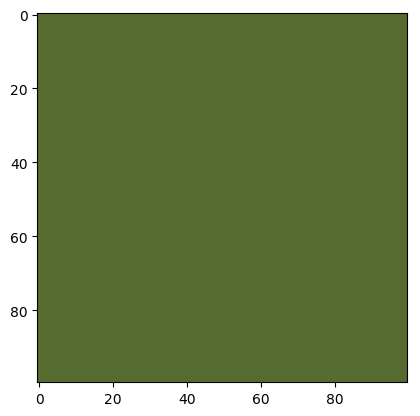

 10000 Arboles(s),      0 Arbole(s) Ardiendo,      0 Celda(s) Quemada(s)


In [6]:
incendio_forestal_estadisticas(0,fill(celda_árbol,dimensión,dimensión),0.01,.05,dimensión)

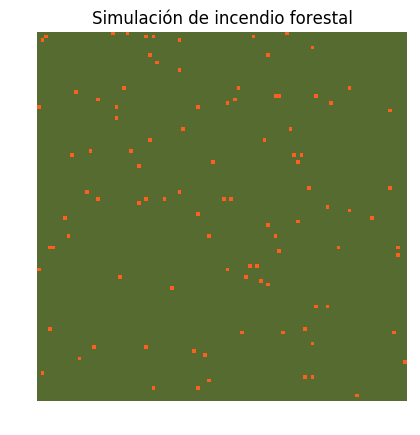


 10000 Número total de celdas,   9902 Arboles(s),     98 Arbole(s) Ardiendo,      0 Celda(s) Quemada(s)


In [7]:
incendio_forestal_estadisticas(1,fill(celda_árbol,dimensión,dimensión),0.01,.05,dimensión)

En el tiempo inicial, se tiene una matriz con todas las celdas verdes; en el tiempo 1, algunas de estas celdas se están incendiando (celdas naranjas).

La propagación del incendio comenzará cuando la prob_fuego sea mayor que un valor escogido, ya que con esta probabilidad se prende una celda incluso si ninguno de sus vecinos se está quemando.

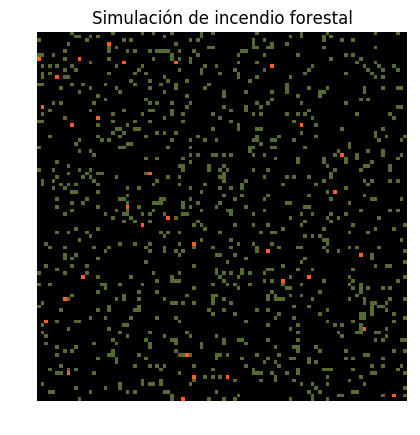


 10000 Número total de celdas,    922 Arboles(s),     32 Arbole(s) Ardiendo,   9046 Celda(s) Quemada(s)


In [15]:
incendio_forestal_estadisticas(10,fill(celda_árbol,dimensión,dimensión),0.1,0.05,dimensión)

### Referencias:

> Reyes D., Descripción y Aplicaciones de los Autómatas Celulares,  Delta.cs.cinvestav.mx. (2017) Disponible en: http://delta.cs.cinvestav.mx/~mcintosh/cellularautomata/Summer_Research_files/Arti_Ver_Inv_2011_DARG.pdf [Recuperado: 28 Noviembre 2017].

> Caparrini, F. and Work, W. (2017). Autómatas Celulares - Fernando Sancho Caparrini. [online] Cs.us.es. Available at: http://www.cs.us.es/~fsancho/?e=66 [Accessed 4 Dec. 2017].

> Euclides.dia.uned.es. (2017). Simulación de incendios forestales utilizando autómatas celulares. [online] Available at: http://www.euclides.dia.uned.es/aurquia/Files/PFC_DavidLatorre.pdf [Accessed 5 Dec. 2017].

> Brilliant.org. (2017). Left to the Reader: Forest Fires. [online] Available at: https://brilliant.org/discussions/thread/forest-fires/ [Accessed 5 Dec. 2017].

> Scipython.com. (2017). The Forest-fire model. [online] Available at: https://scipython.com/blog/the-forest-fire-model/ [Accessed 5 Dec. 2017].

> Genkuroki.github.io. (2017). Examples of animations in Julia by PyPlot and matplotlib.animation. [online] Available at: https://genkuroki.github.io/documents/Jupyter/20170624%20Examples%20of%20animations%20in%20Julia%20by%20PyPlot%20and%20matplotlib.animation.html [Accessed 5 Dec. 2017].

> Web.njit.edu. (2017). RGB to Color Name Mapping(Triplet and Hex). [online] Available at: https://web.njit.edu/~kevin/rgb.txt.html [Accessed 7 Dec. 2017].

> Calhoun, G. (2014). Julia’s macros, expressions, etc. for and by the confused. [online] Gray.clhn.org. Available at: http://gray.clhn.org/dl/macros_etc.pdf [Accessed 7 Dec. 2017].